# Imports

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from mlxtend.evaluate import permutation_test
import statsmodels.api as sm

In [3]:
data = pd.read_csv('./data/df_train.csv')

# Preprocessing

In [7]:
data.drop(columns = 'Unnamed: 0',inplace = True)

In [11]:
data.isna().sum()/len(data)*100

CNT_CHILDREN                    0.000000
AMT_INCOME_TOTAL                0.000000
AMT_CREDIT                      0.000000
REGION_POPULATION_RELATIVE      0.000000
DAYS_BIRTH                      0.000000
DAYS_EMPLOYED                   0.000000
DAYS_REGISTRATION               0.000000
DAYS_ID_PUBLISH                 0.000000
FLAG_EMP_PHONE                  0.000000
FLAG_WORK_PHONE                 0.000000
FLAG_PHONE                      0.000000
REGION_RATING_CLIENT            0.000000
REGION_RATING_CLIENT_W_CITY     0.000000
HOUR_APPR_PROCESS_START         0.000000
REG_REGION_NOT_LIVE_REGION      0.000000
REG_REGION_NOT_WORK_REGION      0.000000
REG_CITY_NOT_LIVE_CITY          0.000000
REG_CITY_NOT_WORK_CITY          0.000000
LIVE_CITY_NOT_WORK_CITY         0.000000
FLAG_DOCUMENT_2                 0.000000
FLAG_DOCUMENT_3                 0.000000
FLAG_DOCUMENT_6                 0.000000
FLAG_DOCUMENT_8                 0.000000
FLAG_DOCUMENT_9                 0.000000
FLAG_DOCUMENT_11

In [13]:
data.drop(columns = ['FONDKAPREMONT_MODE','WALLSMATERIAL_MODE','HOUSETYPE_MODE','EMERGENCYSTATE_MODE','OCCUPATION_TYPE'], inplace = True)

In [14]:
data.dropna(inplace = True)

# Encoding

In [23]:
for col in data.select_dtypes(include = 'object').columns:
    print(f"{col} : {data[col].nunique()}")

### Impact encoding

Pour les variables qu'on ne peut pas OHE en raison de leur nombre de modalités

In [19]:
impact_dicts = {}
categorical_columns = data.select_dtypes(include = 'object')

for categorical_feature in ['ORGANIZATION_TYPE'] :

    category_means = data.groupby(categorical_feature)['TARGET'].mean()
    category_impacts = category_means - category_means.mean()

    impact_dicts[categorical_feature] = category_impacts.to_dict()

    data['encoded_' + categorical_feature] = data[categorical_feature].map(impact_dicts[categorical_feature])
    data.drop(columns= categorical_feature, inplace=True)   

### OHE

In [22]:
categorical_columns = data.select_dtypes(include='object').columns

data = pd.get_dummies(data, columns=categorical_columns, dtype='int')

# Train test split

In [46]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=889)

# Standardisation

In [47]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LOGIT

In [48]:
model = LogisticRegression()

model.fit(X_train_scaled, y_train)

C:\Users\baheu\Documents\M2 MoSEF\Challenge Nexialog\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Résultats

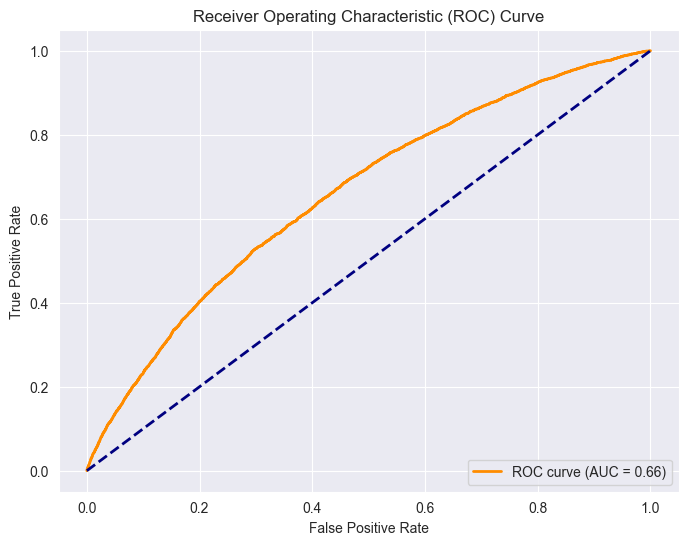

In [49]:
y_prob = model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()